# Client Bank Clustering

**GOAL**

Melakukan clustering data client bank agar dapat **memahami karakter client bank** yang ada terhadap **campaign** yang dilakukan

<img src="https://previews.123rf.com/images/microone/microone2007/microone200700049/150854819-bank-clients-service-banking-office-counter-and-client-service-cash-desk-cashier-atm-professional.jpg" alt="iris" width="700" align=center/>

**Dataset Information**

The data is related with direct marketing campaigns of a Portuguese banking institution. 
The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, on order to access if the product (bank term deposit) would be (or not) subscribed. 
Dataset `bank.csv` ordered by date (from May 2008 to November 2010). 
The **exercise goal** is to discover interesting things about the measurement.

**Variables**

<u>Numeric</u>
- `age`
- `balance`: average yearly balance, in euros
- `duration`: last coontact duration, in seconds
- `campaign`: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
- `previous`: number of contacts performed before this campaign and for this client

<u>Categoric</u>
- `job` : type of job (categorical) 
- `marital` : marital status (categorical)
- `education` (categorical)
- `default`: has credit in default? (binary: "yes","no")
- `housing`: has housing loan? (binary: "yes","no")
- `loan`: has personal loan? (binary: "yes","no")
- `contact`: contact communication type (categorical) 
- `day`: last contact day of the month 
- `month`: last contact month of year (categorical)
- `poutcome`: outcome of the previous marketing campaign (categorical)

Source :  S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. <br>
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

In [1]:
import numpy as np
import pandas as pd

In [2]:
def importData(path, col_to_drop):
    # Read Data
    data = pd.read_csv(path)
    print(f"Data awal                  : {data.shape}, (#observasi, #fitur)")

    # Drop kolom
    data = data.drop(columns = col_to_drop)
    print(f"Data setelah drop kolom    : {data.shape}, (#observasi, #fitur)")

    # Drop duplikat
    print(f"Ada {data.duplicated().sum()} data duplikat")
    data = data.drop_duplicates()
    print(f"Data setelah drop duplikat : {data.shape}, (#observasi, #fitur)")

    return data

In [3]:
filepath = "bank.csv"
col_to_drop = "Unnamed: 0"

data = importData(path = filepath,
                  col_to_drop = col_to_drop)

Data awal                  : (45211, 17), (#observasi, #fitur)
Data setelah drop kolom    : (45211, 16), (#observasi, #fitur)
Ada 0 data duplikat
Data setelah drop duplikat : (45211, 16), (#observasi, #fitur)


In [4]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown


---
### Data Preprocessing

#### Train-Test Split

Kita tidak pisahkan input-output, karena akan menganalisa struktur data

In [5]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data,
                                         test_size = 0.25,
                                         random_state = 123)

In [6]:
print(data_train.shape)
print(data_test.shape)

(33908, 16)
(11303, 16)


#### Numerical & Categorical Split

Mengecek unique value untuk setiap kolom

In [7]:
for col in data_train.columns:
    print(f"col: {col}, #unique: {len(data_train[col].unique())}")

col: age, #unique: 76
col: job, #unique: 12
col: marital, #unique: 3
col: education, #unique: 4
col: default, #unique: 2
col: balance, #unique: 6464
col: housing, #unique: 2
col: loan, #unique: 2
col: contact, #unique: 3
col: day, #unique: 31
col: month, #unique: 12
col: duration, #unique: 1481
col: campaign, #unique: 45
col: pdays, #unique: 521
col: previous, #unique: 37
col: poutcome, #unique: 4


Kita anggap `day` dan `month` sebagai numerik dalam latihan ini
karena jumlah unique valuenya besar.

In [8]:
num_col = ["age", "day", "month", "balance", 
           "duration", "campaign", "pdays", "previous"]
cat_col = list(set(data_train.columns) - set(num_col))

print(num_col)
print(cat_col)

['age', 'day', 'month', 'balance', 'duration', 'campaign', 'pdays', 'previous']
['housing', 'contact', 'poutcome', 'loan', 'marital', 'education', 'default', 'job']


In [9]:
def splitNumCat(data, num_col, cat_col):
    data_num = data[num_col]
    data_cat = data[cat_col]

    return data_num, data_cat

In [10]:
data_train_num, data_train_cat = splitNumCat(data = data_train,
                                             num_col = num_col,
                                             cat_col = cat_col)

In [11]:
data_train_num.head()

,age,day,month,balance,duration,campaign,pdays,previous
26999,32,21,nov,2706,462,3,-1,0
16168,37,22,jul,1396,199,2,-1,0
12338,22,26,jun,-295,150,2,-1,0
6074,36,26,may,-870,102,2,-1,0
7385,50,29,may,429,60,2,-1,0


Fitur `month` perlu di-transform jadi angka

In [12]:
data_train_cat.head()

,housing,contact,poutcome,loan,marital,education,default,job
26999,no,cellular,unknown,no,single,secondary,no,unemployed
16168,yes,cellular,unknown,no,married,secondary,no,admin.
12338,yes,unknown,unknown,no,married,secondary,no,blue-collar
6074,yes,unknown,unknown,no,married,secondary,no,blue-collar
7385,no,unknown,unknown,no,married,primary,no,admin.


#### Handling Data - Impute & Standardize
**Transform** - fitur `month`

In [13]:
def transformMonth(data):
    month_list = ["jan", "feb", "mar", "apr", "may", "jun",
                  "jul", "aug", "sep", "oct", "nov", "dec"]
    number_list = [i+1 for i in range(len(month_list))]

    data["month"] = data["month"].replace(month_list, number_list)

    return data

In [14]:
data_train_num = transformMonth(data = data_train_num)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3028\831587528.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["month"] = data["month"].replace(month_list, number_list)


In [15]:
data_train_num.head()

,age,day,month,balance,duration,campaign,pdays,previous
26999,32,21,11,2706,462,3,-1,0
16168,37,22,7,1396,199,2,-1,0
12338,22,26,6,-295,150,2,-1,0
6074,36,26,5,-870,102,2,-1,0
7385,50,29,5,429,60,2,-1,0


**Missing Values** - Numerical

In [16]:
# Cek missing value
data_train_num.isna().any()

age         False
day         False
month       False
balance     False
duration    False
campaign    False
pdays       False
previous    False
dtype: bool

In [17]:
# Buat imputer, kalau-kalau ada yang butuh di data test
from sklearn.impute import SimpleImputer

def imputerNumeric(data, imputer = None):
    if imputer == None:
        # Buat imputer
        imputer = SimpleImputer(missing_values = np.nan,
                                strategy = "median")
        imputer.fit(data)

    # Transform data
    data_imputed = imputer.transform(data)
    data_imputed = pd.DataFrame(data = data_imputed,
                                columns = data.columns,
                                index = data.index)
    
    return data_imputed, imputer


In [18]:
data_train_num_imputed, num_imputer = imputerNumeric(data = data_train_num)

In [19]:
data_train_num_imputed.head()

,age,day,month,balance,duration,campaign,pdays,previous
26999,32.0,21.0,11.0,2706.0,462.0,3.0,-1.0,0.0
16168,37.0,22.0,7.0,1396.0,199.0,2.0,-1.0,0.0
12338,22.0,26.0,6.0,-295.0,150.0,2.0,-1.0,0.0
6074,36.0,26.0,5.0,-870.0,102.0,2.0,-1.0,0.0
7385,50.0,29.0,5.0,429.0,60.0,2.0,-1.0,0.0


**Standardizing** - Numerical

In [20]:
from sklearn.preprocessing import StandardScaler

# Buat scaler
def fitStandardize(data):
    scaler = StandardScaler()
    scaler.fit(data)

    return scaler

# Transform scaler
def transformStandardize(data, scaler):
    data_scaled = scaler.transform(data)
    data_scaled = pd.DataFrame(data = data_scaled,
                               columns = data.columns,
                               index = data.index)
    
    return data_scaled


In [21]:
# Cari scaler
num_scaler = fitStandardize(data = data_train_num_imputed)

# Transform data
data_train_num_clean = transformStandardize(data = data_train_num_imputed,
                                            scaler = num_scaler)

In [22]:
data_train_num_clean.head()

,age,day,month,balance,duration,campaign,pdays,previous
26999,-0.844906,0.626379,2.024176,0.440092,0.779886,0.077638,-0.411528,-0.242719
16168,-0.373530,0.746689,0.358937,0.006577,-0.231883,-0.246209,-0.411528,-0.242719
12338,-1.787657,1.227931,-0.057373,-0.553021,-0.420387,-0.246209,-0.411528,-0.242719
6074,-0.467806,1.227931,-0.473683,-0.743304,-0.605045,-0.246209,-0.411528,-0.242719
7385,0.852046,1.588862,-0.473683,-0.313430,-0.766620,-0.246209,-0.411528,-0.242719


### Handling Data - PCA (Dimensionality Reduction)

**Goal**: represent data in fewer dimensions

In [23]:
# Import package PCA - Sklearn
from sklearn.decomposition import PCA

# Define PCA with random state
pca_obj = PCA(random_state = 123)

# Fit to data_train_num_clean
pca_obj.fit(data_train_num_clean)

PCA(random_state=123)

In [24]:
# Show PCA Component
pca_component = pca_obj.components_

# Turn to dataframe
pca_component = pd.DataFrame(data = pca_component,
                             columns = data_train_num_clean.columns)
pca_component

,age,day,month,balance,duration,campaign,pdays,previous
0,-0.069772,-0.300405,-0.271369,-0.031820,0.059091,-0.266862,0.639239,0.588984
1,0.442293,0.297602,0.485049,0.480265,-0.128529,0.257602,0.220141,0.344300
2,-0.360480,0.410899,-0.142899,-0.390580,-0.419306,0.538353,0.159648,0.192650
3,-0.374714,0.419159,0.148437,0.015518,0.801606,0.045387,0.056493,0.117457
4,-0.690436,-0.027622,0.117620,0.601584,-0.321183,-0.200227,-0.007981,-0.059021
5,0.138927,0.066414,-0.746403,0.503089,0.152494,0.366869,-0.026452,-0.086753
6,-0.180314,-0.686298,0.260422,0.022065,0.185509,0.624547,-0.033671,0.050689
7,-0.025212,-0.021885,-0.099308,0.007061,-0.027794,-0.076148,-0.715776,0.685614


In [25]:
# Explained variance
pca_obj.explained_variance_

array([1.53187704, 1.19523565, 1.15590508, 0.98118651, 0.89585695,
       0.87547251, 0.81436845, 0.55033375])

In [26]:
# Explained variance ratio
pca_obj.explained_variance_ratio_

array([0.19147898, 0.14940005, 0.14448387, 0.1226447 , 0.11197882,
       0.10943084, 0.10179305, 0.06878969])

bisa dilihat,

PC 1 adalah baris pertama pada dataframe `pca_component`

PC 1 menjelaskan 19.3% variasi data

*transform data dengan principal component*

In [27]:
# Transform data
data_train_num_pca = pca_obj.transform(data_train_num_clean)

# Set data sebagai dataframe
col_names = [f"PC_{i+1}" for i in range(data_train_num_pca.shape[1])]
data_train_num_pca = pd.DataFrame(data = data_train_num_pca,
                                  columns = col_names,
                                  index = data_train_num_clean.index)

data_train_num_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8
26999,-1.073176,0.751500,-0.296867,1.463372,0.820467,-1.185871,0.454034,-0.089753
16168,-0.649881,0.026484,0.239826,0.257520,0.424834,-0.360650,-0.546710,0.110821
12338,-0.576140,-0.902214,1.304431,0.767544,1.062838,-0.524688,-0.777732,0.178573
6074,-0.560112,-0.588036,1.039891,0.060206,0.047435,-0.154479,-1.162590,0.190428
7385,-0.783853,0.330361,0.612266,-0.405923,-0.563307,0.244481,-1.668772,0.156780


*Berapa principal component yang baik?*

Pilih untuk mempertahankan persentase variance tertentu dalam data

In [28]:
# Jika gunakan seluruh component, maka variance-nya
sum(pca_obj.explained_variance_ratio_)

1.0

In [29]:
# Jika memilih n component, maka variance yang dijelaskan
for i in range(1, len(pca_obj.explained_variance_ratio_) + 1):
    sum_of_variance_n = sum(pca_obj.explained_variance_ratio_[:i]) * 100
    print(f"n_component: {i}, %variance explained: {sum_of_variance_n:.2f} %")

n_component: 1, %variance explained: 19.15 %
n_component: 2, %variance explained: 34.09 %
n_component: 3, %variance explained: 48.54 %
n_component: 4, %variance explained: 60.80 %
n_component: 5, %variance explained: 72.00 %
n_component: 6, %variance explained: 82.94 %
n_component: 7, %variance explained: 93.12 %
n_component: 8, %variance explained: 100.00 %


- Apabila ingin mempertahankan 90% variance, maka Anda memilih 7 komponen
- Jumlah komponen yang dipilih dapat dijadikan bagian dari eksperimentasi

*Membuat user-defined function untuk PCA*

In [30]:
def fitPCA(data):
    # Buat objek PCA
    pca_obj = PCA(random_state = 123)

    # Fit PCA pada data
    pca_obj.fit(data)

    # Tampilkan explained-variance
    print("Explained variance using n_components:")
    for i in range(1, len(pca_obj.explained_variance_ratio_) + 1):
        sum_of_variance_n = sum(pca_obj.explained_variance_ratio_[:i]) * 100
        print(f"n_component: {i}, %variance explained: {sum_of_variance_n:.2f} %")

    print()

    # Pilih n_components
    n_comp = int(input("n_components : "))

    # Buat ulang PCA
    pca_obj = PCA(n_components = n_comp,
                  random_state = 123)
    pca_obj.fit(data)

    # Ekstrak komponen
    pca_component = pca_obj.components_[:n_comp]

    # Turn to dataframe
    pca_component = pd.DataFrame(data = pca_component,
                                columns = data.columns)
    
    return pca_component, pca_obj

In [31]:
pca_component, pca_obj = fitPCA(data = data_train_num_clean)

Explained variance using n_components:
n_component: 1, %variance explained: 19.15 %
n_component: 2, %variance explained: 34.09 %
n_component: 3, %variance explained: 48.54 %
n_component: 4, %variance explained: 60.80 %
n_component: 5, %variance explained: 72.00 %
n_component: 6, %variance explained: 82.94 %
n_component: 7, %variance explained: 93.12 %
n_component: 8, %variance explained: 100.00 %



In [32]:
pca_component

,age,day,month,balance,duration,campaign,pdays,previous
0,-0.069772,-0.300405,-0.271369,-0.031820,0.059091,-0.266862,0.639239,0.588984
1,0.442293,0.297602,0.485049,0.480265,-0.128529,0.257602,0.220141,0.344300
2,-0.360480,0.410899,-0.142899,-0.390580,-0.419306,0.538353,0.159648,0.192650
3,-0.374714,0.419159,0.148437,0.015518,0.801606,0.045387,0.056493,0.117457
4,-0.690436,-0.027622,0.117620,0.601584,-0.321183,-0.200227,-0.007981,-0.059021
5,0.138927,0.066414,-0.746403,0.503089,0.152494,0.366869,-0.026452,-0.086753


In [33]:
# Buat fungsi transformasi data
def transformPCA(data, pca_obj):
    # Transform data
    data_pca = pca_obj.transform(data)

    cols = [f"PC_{i+1}" for i in range(data_pca.shape[1])]
    data_pca = pd.DataFrame(data = data_pca,
                            columns = cols,
                            index = data.index)
    
    return data_pca


In [34]:
data_train_num_pca = transformPCA(data = data_train_num_clean,
                                  pca_obj = pca_obj)

In [35]:
# Cek data yang sudah diPCA
data_train_num_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
26999,-1.073176,0.751500,-0.296867,1.463372,0.820467,-1.185871
16168,-0.649881,0.026484,0.239826,0.257520,0.424834,-0.360650
12338,-0.576140,-0.902214,1.304431,0.767544,1.062838,-0.524688
6074,-0.560112,-0.588036,1.039891,0.060206,0.047435,-0.154479
7385,-0.783853,0.330361,0.612266,-0.405923,-0.563307,0.244481


In [36]:
# Cek komponen
pca_component

,age,day,month,balance,duration,campaign,pdays,previous
0,-0.069772,-0.300405,-0.271369,-0.031820,0.059091,-0.266862,0.639239,0.588984
1,0.442293,0.297602,0.485049,0.480265,-0.128529,0.257602,0.220141,0.344300
2,-0.360480,0.410899,-0.142899,-0.390580,-0.419306,0.538353,0.159648,0.192650
3,-0.374714,0.419159,0.148437,0.015518,0.801606,0.045387,0.056493,0.117457
4,-0.690436,-0.027622,0.117620,0.601584,-0.321183,-0.200227,-0.007981,-0.059021
5,0.138927,0.066414,-0.746403,0.503089,0.152494,0.366869,-0.026452,-0.086753


**Membuat bi-plot**

In [37]:
import matplotlib.pyplot as plt
transformed_data = data_train_num_clean @ pca_component[:2].T
transformed_data.head()

,0,1
26999,-1.073176,0.751500
16168,-0.649881,0.026484
12338,-0.576140,-0.902214
6074,-0.560112,-0.588036
7385,-0.783853,0.330361


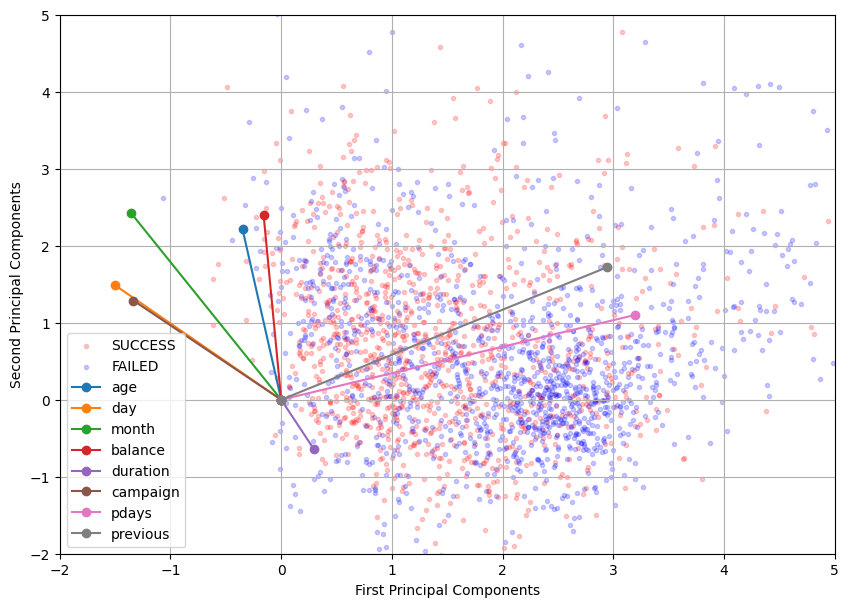

In [38]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 7))

ax.scatter(transformed_data[0][data_train_cat["poutcome"]=="success"], 
           transformed_data[1][data_train_cat["poutcome"]=="success"], 
           marker=".", 
           c="red", #s=10,
           alpha=.2,
           label = "SUCCESS")

ax.scatter(transformed_data[0][data_train_cat["poutcome"]=="other"], 
           transformed_data[1][data_train_cat["poutcome"]=="other"], 
           marker=".", 
           c="blue", #s=10,
           alpha=.2,
           label = "FAILED")

for col in pca_component.columns:
    data_col = np.array(pca_component[col].loc[0:1])*5.
    start_point = [0, data_col[0]]
    end_point = [0, data_col[1]]

    ax.plot(start_point, end_point, marker="o", label=col)

ax.set_ylabel("Second Principal Components")
ax.set_xlabel("First Principal Components")
ax.set_xlim([-2.0, 5])
ax.set_ylim([-2.0, 5])
plt.grid()
plt.legend()
plt.show()

Bagaimana cara interpretasinya?
- Untuk PC_1, memberi bobot besar pada `pdays` dan `previous`, tapi bobot untuk `duration`, `balance` dan `age` kecil
- Artinya `pdays` dan `previous` berkorelasi satu sama lain,
- Semakin besar `previous`, semakin besar `pdays`

---
### Modeling Clustering - Data Full
- **Goal**: make separate group with similar character, and assign them into cluster
- **TASK CLUSTERING IS SUBJECTIVE**

In [40]:
from sklearn.cluster import KMeans

# Buat objek k-means
kmeans_obj = KMeans(n_clusters = 3,
                    random_state = 123)

# Fit objek k-means
kmeans_obj.fit(data_train_num_clean)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


KMeans(n_clusters=3, random_state=123)

In [41]:
# Predict Cluster
kmeans_obj.predict(data_train_num_clean)

array([0, 0, 0, ..., 0, 0, 0])

In [42]:
# Reshape predicted cluster to dataframe
cluster_result = kmeans_obj.predict(data_train_num_clean)
cluster_result = pd.DataFrame(data = cluster_result,
                              columns = ["cluster"],
                              index = data_train_num_clean.index)

In [43]:
cluster_result.head()

,cluster
26999,0
16168,0
12338,0
6074,0
7385,0


In [44]:
# Periksa proporsi cluster
cluster_result["cluster"].value_counts(normalize = True)

cluster
0    0.438156
2    0.433231
1    0.128613
Name: proportion, dtype: float64

**2 cluster memiliki porsi di atas 43% data**

*periksa centroid* sebagai representasi cluster

In [45]:
# Check centroid
kmeans_obj.cluster_centers_

array([[ 0.03937912,  0.85322693,  0.37342149,  0.08001659, -0.12595164,
         0.25195196, -0.30958848, -0.17262413],
       [-0.04313517, -0.2740182 , -0.53431553,  0.00767733,  0.00491422,
        -0.19510653,  2.31023679,  1.28068678],
       [-0.02703145, -0.78176728, -0.21914726, -0.08322143,  0.12595067,
        -0.19695621, -0.37255478, -0.20551245]])

In [46]:
# Jadikan dataframe
centroids = kmeans_obj.cluster_centers_
centroids = pd.DataFrame(data = centroids,
                         columns = data_train_num_clean.columns)

centroids

,age,day,month,balance,duration,campaign,pdays,previous
0,0.039379,0.853227,0.373421,0.080017,-0.125952,0.251952,-0.309588,-0.172624
1,-0.043135,-0.274018,-0.534316,0.007677,0.004914,-0.195107,2.310237,1.280687
2,-0.027031,-0.781767,-0.219147,-0.083221,0.125951,-0.196956,-0.372555,-0.205512


- Tentu hal diatas tidak bisa diartikan
- Karena dalam bentuk terstandardkan
- Kita harus balikan ke dalam bentuk awal sebelum distandarisasi

*inverse transform dari standardizer*

In [47]:
centroid_real = num_scaler.inverse_transform(centroids)
centroid_real = pd.DataFrame(data = centroid_real,
                             columns = data_train_num_clean.columns)

centroid_real

,age,day,month,balance,duration,campaign,pdays,previous
0,41.379837,22.885524,7.034794,1617.919308,226.535837,3.538260,9.191130,0.167373
1,40.504587,13.516055,4.854358,1399.323853,260.553211,2.157798,271.100917,3.637615
2,40.675403,9.295731,5.611410,1124.645109,292.015522,2.152087,2.896249,0.088842


*lalu artinya apa?* - Harus di translate sendiri

Cluster 1 (0) adalah **group** yang
- dikontak di awal bulan
- sudah pernah dikontak 2x **selama** campaign
- belum pernah dikontak **sebelum** campaign

*BEST K?*

Score -- within-cluster sum-of-squares

$$
\text{scores} = - \sum_{i=0}^{n} ||x_{i} - \mu_{j}||^{2}
$$

In [48]:
# Tampilkan score
-kmeans_obj.score(data_train_num_clean)

209784.98744710835

*coba variasikan beberapa cluster*

In [49]:
score_list = []
k_list = np.arange(2, 11, 1)

for k in k_list:
    # Buat object
    kmeans_obj_k = KMeans(n_clusters = k,
                          max_iter = 50,
                          random_state = 123)
    
    # Fit data
    kmeans_obj_k.fit(data_train_num_clean)

    # update score
    score_k = -kmeans_obj_k.score(data_train_num_clean)
    score_list.append(score_k)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\clus

In [50]:
score_list

[234084.3344467303,
 209784.98744710837,
 191703.13257109828,
 175540.00432668623,
 158902.7450404901,
 145745.07660011106,
 135044.3383715455,
 122120.67849306182,
 115321.43914771419]

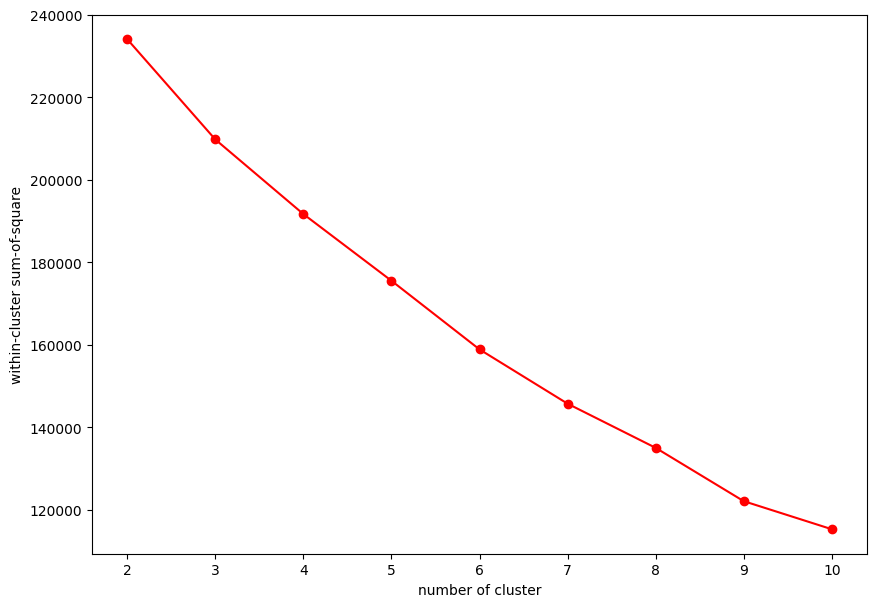

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

ax.plot(k_list, score_list, "r", marker="o")

ax.set_xlabel("number of cluster")
ax.set_ylabel("within-cluster sum-of-square")
plt.show()

- Makin banyak cluster, makin rendah scorenya.
- Tapi, makin banyak cluster, makin kompleks untuk diinterpretasikan.
- Kita coba ambil cluster terbaik di 9, karena perubahan error di cluster 10 mengecil

In [52]:
# Buat object
kmeans_obj_best = KMeans(n_clusters = 9,
                         random_state = 123)

# Fit object
kmeans_obj_best.fit(data_train_num_clean)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=9, random_state=123)

In [53]:
# Jadikan centroid dalam bentuk dataframe
centroids_best = kmeans_obj_best.cluster_centers_
centroids_best = pd.DataFrame(data = centroids_best,
                              columns = data_train_num_clean.columns)

# Inverse transform
centroid_real_best = num_scaler.inverse_transform(centroids_best)
centroid_real_best = pd.DataFrame(data = centroid_real_best,
                                  columns = data_train_num_clean.columns)

centroid_real_best

,age,day,month,balance,duration,campaign,pdays,previous
0,54.604860,13.276118,6.127225,1246.759016,209.813806,2.462312,7.212970,0.165764
1,37.140534,24.772936,5.601490,852.452514,201.419615,2.683426,1.984109,0.065549
2,40.634561,22.265345,6.774315,971.484419,146.050047,15.700661,0.035883,0.030217
3,39.332783,13.245875,4.406766,1087.734873,234.671892,2.177668,290.418867,3.548680
4,40.748892,15.648941,6.163466,1286.755293,1008.479074,2.435746,15.535204,0.259970
5,41.077538,18.198284,10.733649,1860.238532,215.559337,1.827168,50.182598,0.980172
6,34.803790,8.665819,5.427201,826.768200,216.659348,2.178068,2.689970,0.080656
7,40.000000,2.000000,2.000000,543.000000,349.000000,2.000000,262.000000,275.000000
8,44.517405,16.132911,7.056962,16932.697785,243.090190,2.458861,28.272152,0.482595


**Predict Cluster**

In [54]:
cluster_best = kmeans_obj_best.predict(data_train_num_clean)

cluster_best = pd.DataFrame(data = cluster_best,
                            columns = ["cluster"],
                            index= data_train_num_clean.index)
cluster_best.head()

,cluster
26999,5
16168,1
12338,1
6074,1
7385,1


---
### Modeling Clustering - Data PCA

*Variasikan beberapa cluster*

In [55]:
score_list = []
k_list = np.arange(2, 11, 1)

for k in k_list:
    # Buat object
    kmeans_obj_k = KMeans(n_clusters = k,
                          max_iter = 50,
                          random_state = 123)
    
    # Fit data
    kmeans_obj_k.fit(data_train_num_pca)

    # update score
    score_k = -kmeans_obj_k.score(data_train_num_pca)
    score_list.append(score_k)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\clus

In [56]:
score_list

[190061.87607586075,
 166776.42959659887,
 150015.32793220106,
 133921.04031916935,
 120306.698308458,
 108332.43396555317,
 101222.13292847504,
 96821.63676580845,
 89734.20970110146]

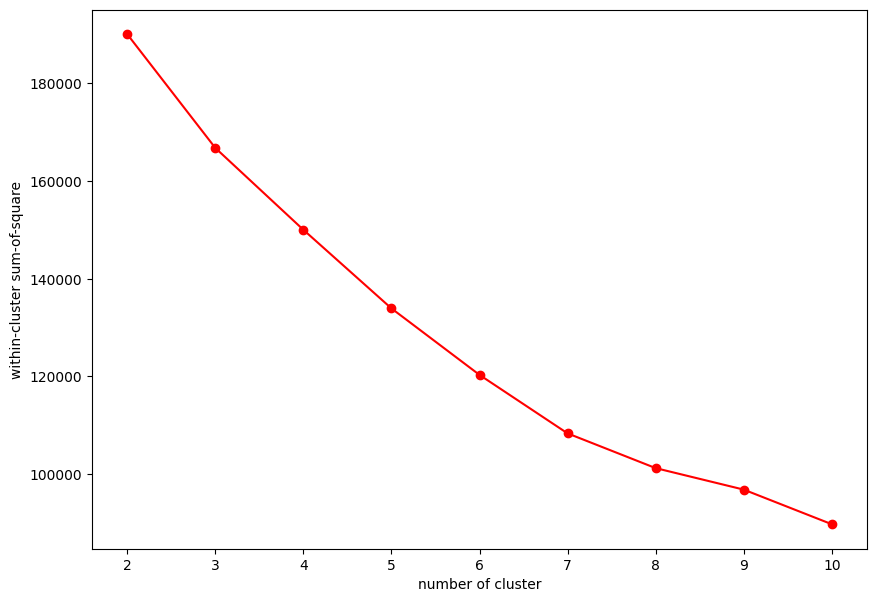

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

ax.plot(k_list, score_list, "r", marker="o")

ax.set_xlabel("number of cluster")
ax.set_ylabel("within-cluster sum-of-square")
plt.show()

- Makin banyak cluster, makin rendah scorenya.
- Tapi, makin banyak cluster, makin kompleks untuk diinterpretasikan.
- Kita coba ambil cluster terbaik di 7, karena perubahan error di cluster selanjutnya mengecil

In [58]:
# Buat object
kmeans_obj_pca_best = KMeans(n_clusters = 7,
                             random_state = 123)

# Fit object
kmeans_obj_pca_best.fit(data_train_num_pca)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=7, random_state=123)

**Predict Cluster**

In [59]:
cluster_pca_best = kmeans_obj_pca_best.predict(data_train_num_pca)

cluster_pca_best = pd.DataFrame(data = cluster_pca_best,
                                columns = ["cluster"],
                                index = data_train_num_pca.index)
cluster_pca_best.head()

,cluster
26999,0
16168,0
12338,5
6074,5
7385,1


In [60]:
# Cari centroid
centroid_pca_best = kmeans_obj_pca_best.cluster_centers_
centroid_pca_best = pd.DataFrame(data = centroid_pca_best,
                                 columns = data_train_num_pca.columns)
centroid_pca_best

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
0,-0.606478,0.767474,0.025522,0.252602,0.298534,-1.084011
1,-0.236993,0.167790,-0.608284,-0.806180,-0.730189,0.124474
2,2.670768,0.440839,0.636797,0.037757,-0.060899,0.145607
3,-0.078825,-0.512625,-1.155161,2.163038,-0.829000,0.407610
4,-1.504373,0.939210,1.939613,0.179895,-0.506180,0.778747
5,-0.105925,-0.840818,0.178404,-0.081011,0.440697,0.037082
6,-0.367673,2.694139,-2.141067,-0.027174,2.869796,2.185303


In [61]:
# Inverse transform centroid pca
# agar dapat diinterpretasikan
centroid_pca_best_inv = pca_obj.inverse_transform(centroid_pca_best)
centroid_pca_best_inv = pd.DataFrame(centroid_pca_best_inv,
                                     columns = data_train_num_clean.columns)
centroid_pca_best_inv

,age,day,month,balance,duration,campaign,pdays,previous
0,-0.078807,0.446718,1.414912,0.016080,-0.203883,-0.072711,-0.174095,0.018043
1,1.133551,-0.438297,-0.065837,-0.063451,-0.173247,-0.065725,-0.254677,-0.261394
2,-0.172790,-0.382278,-0.712173,-0.084781,-0.093826,-0.189019,1.904735,1.842896
3,0.013660,0.353093,-0.142858,-0.052589,2.607918,-0.319201,-0.229626,-0.177834
4,0.211444,1.669523,-0.027457,-0.168574,-0.597365,2.082814,-0.451636,-0.205568
5,-0.697574,-0.188769,-0.392455,-0.187611,-0.173824,-0.170596,-0.233402,-0.356254
6,0.321433,0.086945,0.414915,4.967264,-0.080505,-0.134642,-0.066005,-0.063591


In [62]:
# Inverse transform centroid standardisasi
# agar dapat diinterpretasikan
centroid_pca_best_real = num_scaler.inverse_transform(centroid_pca_best_inv)
centroid_pca_best_real = pd.DataFrame(centroid_pca_best_real,
                                      columns = data_train_num_clean.columns)

centroid_pca_best_real

,age,day,month,balance,duration,campaign,pdays,previous
0,40.126210,19.506695,9.536514,1424.715229,206.278266,2.535740,22.736684,0.622653
1,52.985999,12.150599,5.979669,1184.388022,214.241971,2.557313,14.680734,-0.044593
2,39.129303,12.616217,4.427134,1119.932234,234.886724,2.176596,230.562042,4.980068
3,41.107025,18.728496,5.794661,1217.211838,937.180109,1.774610,17.185115,0.154932
4,43.204973,29.670437,6.071860,866.725054,103.996208,9.191736,-5.009676,0.088709
5,33.562789,14.224630,5.195114,809.199587,214.091779,2.233483,16.807646,-0.271102
6,44.371652,16.516318,7.134463,16386.251372,238.349258,2.344507,33.542751,0.427723


**Sekarang, data bisa diinterpretasikan**

---
#### Clustering Test Data

*Preprocessing Test Data*

In [63]:
def transformTestData(data, num_col, cat_col, num_imputer, num_scaler):
    # 1. Split num-cat data
    data_num, _ = splitNumCat(data = data,
                              num_col = num_col,
                              cat_col = cat_col)
    
    # 2. Handling Data
    # 2.1 transform month
    data_num = transformMonth(data = data_num)

    # 2.2 impute data
    data_num_imputed, _= imputerNumeric(data = data_train_num,
                                        imputer = num_imputer)
    
    # 2.3 Standardization
    data_num_scaled = transformStandardize(data = data_num_imputed,
                                           scaler = num_scaler)
    return data_num_scaled

In [64]:
data_test_clean = transformTestData(data = data_test,
                                    num_col = num_col,
                                    cat_col = cat_col,
                                    num_imputer = num_imputer,
                                    num_scaler = num_scaler)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3028\831587528.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["month"] = data["month"].replace(month_list, number_list)


In [65]:
data_test_clean.head()

,age,day,month,balance,duration,campaign,pdays,previous
26999,-0.844906,0.626379,2.024176,0.440092,0.779886,0.077638,-0.411528,-0.242719
16168,-0.373530,0.746689,0.358937,0.006577,-0.231883,-0.246209,-0.411528,-0.242719
12338,-1.787657,1.227931,-0.057373,-0.553021,-0.420387,-0.246209,-0.411528,-0.242719
6074,-0.467806,1.227931,-0.473683,-0.743304,-0.605045,-0.246209,-0.411528,-0.242719
7385,0.852046,1.588862,-0.473683,-0.313430,-0.766620,-0.246209,-0.411528,-0.242719


*Transform PCA*

In [66]:
data_test_clean_pca = transformPCA(data = data_test_clean,
                                   pca_obj = pca_obj)

In [67]:
data_test_clean_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
26999,-1.073176,0.751500,-0.296867,1.463372,0.820467,-1.185871
16168,-0.649881,0.026484,0.239826,0.257520,0.424834,-0.360650
12338,-0.576140,-0.902214,1.304431,0.767544,1.062838,-0.524688
6074,-0.560112,-0.588036,1.039891,0.060206,0.047435,-0.154479
7385,-0.783853,0.330361,0.612266,-0.405923,-0.563307,0.244481


#### Predict Test Data

*predict data test - FULL*

In [68]:
kmeans_obj_best.predict(data_test_clean)

array([5, 1, 1, ..., 1, 1, 1])

*predict data test - PCA*

In [69]:
kmeans_obj_pca_best.predict(data_test_clean_pca)

array([0, 0, 5, ..., 0, 1, 0])